# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/toxiccomments_train.csv', my_random_seed=777)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier()
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12932, 'TN': 114583, 'FP': 81, 'FN': 60, 'Accuracy': 0.9988954690731341, 'Precision': 0.9937754553139169, 'Recall': 0.9953817733990148, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12887, 'TN': 114563, 'FP': 101, 'FN': 105, 'Accuracy': 0.9983862881494016, 'Precision': 0.9922235910070835, 'Recall': 0.9919181034482759, 'desc': 'svm_train'}


In [7]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc = LinearSVC(random_state=0, tol=1e-5, C=5.0)
svc.fit(X_train, y_train)

svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svm_train')
svc_performance_train.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12884, 'TN': 114336, 'FP': 328, 'FN': 108, 'Accuracy': 0.9965845710346556, 'Precision': 0.9751740841659098, 'Recall': 0.9916871921182266, 'desc': 'svm_train'}


/Users/stephaniewu/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc_00005 = LinearSVC(random_state=0, tol=1e-5, C=0.00005)
svc_00005.fit(X_train, y_train)

svc_00005_performance_train = BinaryClassificationPerformance(svc_00005.predict(X_train), y_train, 'svm_00005_train')
svc_00005_performance_train.compute_measures()
print(svc_00005_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12134, 'TN': 114428, 'FP': 236, 'FN': 858, 'Accuracy': 0.9914300933759479, 'Precision': 0.9809215844785772, 'Recall': 0.9339593596059114, 'desc': 'svm_00005_train'}


In [9]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc_005 = LinearSVC(random_state=0, tol=1e-5, C=0.005)
svc_005.fit(X_train, y_train)

svc_005_performance_train = BinaryClassificationPerformance(svc_005.predict(X_train), y_train, 'svm_005_train')
svc_005_performance_train.compute_measures()
print(svc_005_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12913, 'TN': 114603, 'FP': 61, 'FN': 79, 'Accuracy': 0.9989033026258068, 'Precision': 0.9952982888854632, 'Recall': 0.9939193349753694, 'desc': 'svm_005_train'}


/Users/stephaniewu/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc_05 = LinearSVC(random_state=0, tol=1e-5, C=0.05)
svc_05.fit(X_train, y_train)

svc_05_performance_train = BinaryClassificationPerformance(svc_05.predict(X_train), y_train, 'svm_05_train')
svc_05_performance_train.compute_measures()
print(svc_05_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12949, 'TN': 114603, 'FP': 61, 'FN': 43, 'Accuracy': 0.999185310522028, 'Precision': 0.9953112990007686, 'Recall': 0.9966902709359606, 'desc': 'svm_05_train'}


/Users/stephaniewu/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc_500 = LinearSVC(random_state=0, tol=1e-5, C=500.0)
svc_500.fit(X_train, y_train)

svc_500_performance_train = BinaryClassificationPerformance(svc_500.predict(X_train), y_train, 'svm_500_train')
svc_500_performance_train.compute_measures()
print(svc_500_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12910, 'TN': 114333, 'FP': 331, 'FN': 82, 'Accuracy': 0.9967647427461303, 'Precision': 0.9750018880749188, 'Recall': 0.9936884236453202, 'desc': 'svm_500_train'}


/Users/stephaniewu/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
svc_50000 = LinearSVC(random_state=0, tol=1e-5, C=50000.0)
svc_50000.fit(X_train, y_train)

svc_50000_performance_train = BinaryClassificationPerformance(svc_50000.predict(X_train), y_train, 'svm_50000_train')
svc_50000_performance_train.compute_measures()
print(svc_50000_performance_train.performance_measures)

{'Pos': 12992, 'Neg': 114664, 'TP': 12910, 'TN': 114364, 'FP': 300, 'FN': 82, 'Accuracy': 0.9970075828789873, 'Precision': 0.9772899318697956, 'Recall': 0.9936884236453202, 'desc': 'svm_50000_train'}


/Users/stephaniewu/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### MODEL: logistic regression

### ROC plot to compare performance of various models and fits

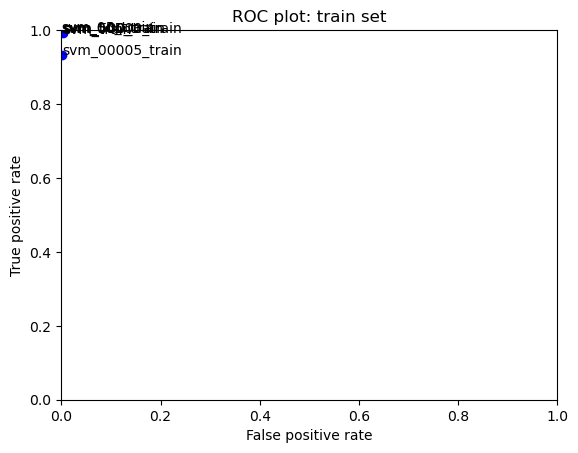

In [13]:
fits = [svc_performance_train, svc_00005_performance_train, svc_005_performance_train, svc_05_performance_train,svc_500_performance_train, svc_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

### MODEL: SVC, linear

In [14]:
svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svm_test')
svc_performance_test.compute_measures()
print(svc_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2195, 'TN': 26373, 'FP': 2309, 'FN': 1038, 'Accuracy': 0.8951276829077236, 'Precision': 0.4873445825932504, 'Recall': 0.6789359727806991, 'desc': 'svm_test'}


In [15]:
svc_00005_performance_test = BinaryClassificationPerformance(svc_00005.predict(X_test), y_test, 'svm_00005_test')
svc_00005_performance_test.compute_measures()
print(svc_00005_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2096, 'TN': 27938, 'FP': 744, 'FN': 1137, 'Accuracy': 0.9410621964593452, 'Precision': 0.7380281690140845, 'Recall': 0.6483142592019796, 'desc': 'svm_00005_test'}


In [16]:
svc_005_performance_test = BinaryClassificationPerformance(svc_005.predict(X_test), y_test, 'svm_005_test')
svc_005_performance_test.compute_measures()
print(svc_005_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2204, 'TN': 27323, 'FP': 1359, 'FN': 1029, 'Accuracy': 0.925176249412502, 'Precision': 0.6185798484423238, 'Recall': 0.681719764924219, 'desc': 'svm_005_test'}


In [17]:
svc_05_performance_test = BinaryClassificationPerformance(svc_05.predict(X_test), y_test, 'svm_05_test')
svc_05_performance_test.compute_measures()
print(svc_05_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2167, 'TN': 27093, 'FP': 1589, 'FN': 1066, 'Accuracy': 0.9168102772990757, 'Precision': 0.5769435569755058, 'Recall': 0.6702752861119703, 'desc': 'svm_05_test'}


In [18]:
svc_500_performance_test = BinaryClassificationPerformance(svc_500.predict(X_test), y_test, 'svm_500_test')
svc_500_performance_test.compute_measures()
print(svc_500_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2192, 'TN': 26241, 'FP': 2441, 'FN': 1041, 'Accuracy': 0.8908976970076766, 'Precision': 0.4731275631340384, 'Recall': 0.6780080420661924, 'desc': 'svm_500_test'}


In [19]:
svc_50000_performance_test = BinaryClassificationPerformance(svc_50000.predict(X_test), y_test, 'svm_50000_test')
svc_50000_performance_test.compute_measures()
print(svc_50000_performance_test.performance_measures)

{'Pos': 3233, 'Neg': 28682, 'TP': 2191, 'TN': 26233, 'FP': 2449, 'FN': 1042, 'Accuracy': 0.8906156979476735, 'Precision': 0.472198275862069, 'Recall': 0.6776987318280235, 'desc': 'svm_50000_test'}


### ROC plot to compare performance of various models and fits

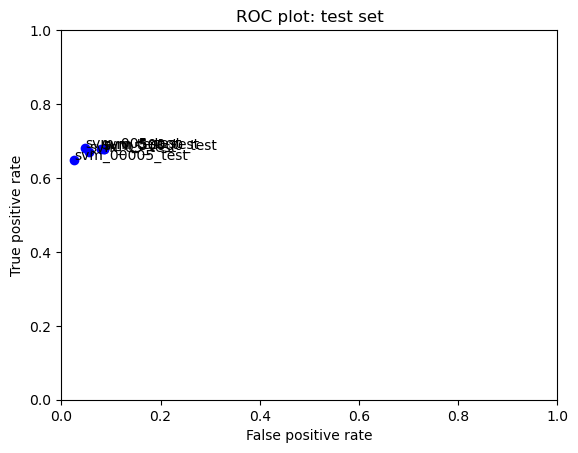

In [20]:
fits = [svc_performance_test, svc_00005_performance_test, svc_005_performance_test, svc_05_performance_test,svc_500_performance_test, svc_50000_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [21]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/toxiccomments_test.csv', my_random_seed=777, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [22]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission.mean())

Series([], dtype: float64)


/var/folders/4r/yn9hxr6s4f703zgmn15r74600000gn/T/ipykernel_9917/464574394.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(my_submission.mean())


In [23]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [24]:
my_submission.head()

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb


In [25]:
my_submission.shape

(153164, 1)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../submission/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation